In [1]:
N_NEIGHBORS = 11

# CONSTANTES CONTENT BASED

# CAMINHOS

PATH_TO_FULL_CB_FILE = "../../preprocessed-data/CB/data_cb.pkl"

PATH_TO_MOVIES_CB_FILE = "../../preprocessed-data/CB/movies_cb.pkl"

PATH_TO_RATINGS_CB_FILE = "../../preprocessed-data/CB/ratings_cb.pkl"

PATH_TO_RATINGS_INFOS_CB_FILE = "../../preprocessed-data/CB/ratings_info_cb.pkl"

PATH_TO_TAG_RELEVANCE_GROUPED_CB_FILE = "../../preprocessed-data/CB/tag_relevance_grouped_cb.pkl"

PATH_TO_TAG_RELEVANCE_CB_FILE = "../../preprocessed-data/CB/tag_relevance_cb.pkl"

PATH_TO_TAGS_PROCESSED_CB_FILE = "../../preprocessed-data/CB/tags_processed_cb.pkl"

# DataFrames Names

# data_cb = arquivo completo 
# movies_cb = arquivos de filmes
# ratings_cb = arquivos de ratings
# ratings_infos_cb = arquivos de informações sobre os ratings
# tag_relevance_grouped_cb = relevancia de tags após o agrupamento
# tag_relevance_cb = relevancia de tags original
# tags_processed_cb = tags todas juntas em uma coluna e processadas pelo nltk

In [2]:
# Importando bibliotecas necessárias
import pandas as pd
pd.set_option("display.max_rows", 25)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import sys

# Importando garbage collector
import gc

# Importando bibliotecas para o sistema de recomendação
import scipy.sparse as sparse # Matriz esparsa (csr_matrix)

# Importando sklearn
import sklearn
from sklearn.neighbors import NearestNeighbors

# Importando Regular Expression operations
import re

# 1 - Preparação dos dados para Content Based

In [3]:
def load_cb_files(full=True, movies=False, ratings=False, ratings_infos=False ,relevance_grouped=False, relevance=False, tags_processed=False):
    data_cb = None
    movies_cb = None 
    ratings_cb = None
    ratings_infos_cb = None
    tag_relevance_grouped_cb = None
    tag_relevance_cb = None
    tags_processed_cb = None
    
    # Caso se queira carregar o completo
    if(full):
        data_cb = pd.read_pickle(PATH_TO_FULL_CB_FILE)
        print("Arquivo completo: Carregado com sucesso!")
    else:
        print("Arquivo completo: Não foi carregado, verifique se era o que desejava.")
    
    # Caso queira-se carregar o arquivo de filmes
    if(movies):
        movies_cb = pd.read_pickle(PATH_TO_MOVIES_CB_FILE)
        print("Arquivo movies: Carregado com sucesso!")
    else:
        print("Arquivo movies: Não foi carregado, verifique se era o que desejava.")
        
    if(ratings):
        ratings_cb = pd.read_pickle(PATH_TO_RATINGS_CB_FILE)
        print("Arquivo ratings: Carregado com sucesso!")
    else:
        print("Arquivo ratings: Não foi carregado, verifique se era o que desejava.")
    
    if(ratings_infos):
        ratings_infos_cb = pd.read_pickle(PATH_TO_RATINGS_INFOS_CB_FILE)
        print("Arquivo ratings infos: Carregado com sucesso!")
    else:
        print("Arquivo ratings infos: Não foi carregado, verifique se era o que desejava.")
        
    if(relevance_grouped):
        tag_relevance_grouped_cb = pd.read_pickle(PATH_TO_TAG_RELEVANCE_GROUPED_CB_FILE)
        print("Arquivo relevance grouped: Carregado com sucesso!")
    else:
        print("Arquivo relevance grouped: Não foi carregado, verifique se era o que desejava.")
    
    if(relevance):
        tag_relevance_cb = pd.read_pickle(PATH_TO_TAG_RELEVANCE_CB_FILE)
        print("Arquivo relevance: Carregado com sucesso!")
    else:
        print("Arquivo relevance: Não foi carregado, verifique se era o que desejava.")
        
    if(tags_processed):
        tags_processed_cb = pd.read_pickle(PATH_TO_TAGS_PROCESSED_CB_FILE)
        print("Arquivo tags processed: Carregado com sucesso!")
    else:
        print("Arquivo tags processed: Não foi carregado, verifique se era o que desejava.")
        
        
    return data_cb, movies_cb, ratings_cb, ratings_infos_cb, tag_relevance_grouped_cb, tag_relevance_cb, tags_processed_cb
    

In [4]:
data_cb, movies_cb, ratings_cb, ratings_infos_cb, tag_relevance_grouped_cb, tag_relevance_cb, tags_processed_cb = load_cb_files(full=True, movies=True, ratings_infos=True, tags_processed=True)

Arquivo completo: Carregado com sucesso!
Arquivo movies: Carregado com sucesso!
Arquivo ratings: Não foi carregado, verifique se era o que desejava.
Arquivo ratings infos: Carregado com sucesso!
Arquivo relevance grouped: Não foi carregado, verifique se era o que desejava.
Arquivo relevance: Não foi carregado, verifique se era o que desejava.
Arquivo tags processed: Carregado com sucesso!


In [5]:
movies_cb.head()

movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   

                                              genres  year  
0  [Adventure, Animation, Children, Comedy, Fantasy]  1995  
1                     [Adventure, Children, Fantasy]  1995  
2                                  [Comedy, Romance]  1995  
3                           [Comedy, Drama, Romance]  1995  
4                                           [Comedy]  1995

In [6]:
data_cb.tail()

movieId                            title                    genres  \
13811   205072           Zombieland: Double Tap  [Action, Comedy, Horror]   
13812   205076                    Downton Abbey                   [Drama]   
13813   205383  El Camino: A Breaking Bad Movie  [Crime, Drama, Thriller]   
13814   205425  Dave Chappelle: Sticks & Stones                  [Comedy]   
13815   206499     Between Two Ferns: The Movie                  [Comedy]   

       year  average rating  rating count  weighted rating  \
13811  2019        3.310345            58         3.100801   
13812  2019        3.216981            53         3.087934   
13813  2019        3.642857           252         3.287936   
13814  2019        3.543478            69         3.138957   
13815  2019        3.055556            90         3.068544   

                                                     tag  \
13811  [007, 007 (series), 18th century, 1920s, 1930s...   
13812  [007, 007 (series), 18th century, 1920s, 1930s...   
13813  [007, 007 (series), 18th century, 1920s, 1930s...   
13814  [007, 007 (series), 18th century, 1920s, 1930s...   
13815  [007, 007 (series), 18th century, 1920s, 1930s...   

                                               relevance  
13811  [1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, ...  
13812  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...  
13813  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...  
13814  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...  
13815  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, ...

## 1.1 Separando gêneros em colunas diferentes

In [7]:
movies_genres_separated_cb = movies_cb.copy()

genres_list = []
#Para cada linha no dataframe, iteramos pela lista de generos e colocamos 1 na coluna correspondente
for index, row in movies_genres_separated_cb.iterrows():
    for genre in row['genres']:
        movies_genres_separated_cb.at[index, genre] = 1
        if(not genre in genres_list):
            genres_list.append(genre)


#Todos os valores não preenchidos se tornam 0
movies_genres_separated_cb = movies_genres_separated_cb.fillna(0)

#Renomeando a coluna '(no genres listed)' para 'None'
movies_genres_separated_cb.rename({"(no genres listed)":"None"}, axis=1, inplace=True)

In [8]:
movies_genres_separated_cb

movieId                        title  \
0            1                    Toy Story   
1            2                      Jumanji   
2            3             Grumpier Old Men   
3            4            Waiting to Exhale   
4            5  Father of the Bride Part II   
...        ...                          ...   
62418   209157                           We   
62419   209159           Window of the Soul   
62420   209163                    Bad Poems   
62421   209169                 A Girl Thing   
62422   209171      Women of Devil's Island   

                                                  genres  year  Adventure  \
0      [Adventure, Animation, Children, Comedy, Fantasy]  1995        1.0   
1                         [Adventure, Children, Fantasy]  1995        1.0   
2                                      [Comedy, Romance]  1995        0.0   
3                               [Comedy, Drama, Romance]  1995        0.0   
4                                               [Comedy]  1995        0.0   
...                                                  ...   ...        ...   
62418                                            [Drama]  2018        0.0   
62419                                      [Documentary]  2001        0.0   
62420                                    [Comedy, Drama]  2018        0.0   
62421                               [(no genres listed)]  2001        0.0   
62422                         [Action, Adventure, Drama]  1962        1.0   

       Animation  Children  Comedy  Fantasy  Romance  ...  Horror  Mystery  \
0            1.0       1.0     1.0      1.0      0.0  ...     0.0      0.0   
1            0.0       1.0     0.0      1.0      0.0  ...     0.0      0.0   
2            0.0       0.0     1.0      0.0      1.0  ...     0.0      0.0   
3            0.0       0.0     1.0      0.0      1.0  ...     0.0      0.0   
4            0.0       0.0     1.0      0.0      0.0  ...     0.0      0.0   
...          ...       ...     ...      ...      ...  ...     ...      ...   
62418        0.0       0.0     0.0      0.0      0.0  ...     0.0      0.0   
62419        0.0       0.0     0.0      0.0      0.0  ...     0.0      0.0   
62420        0.0       0.0     1.0      0.0      0.0  ...     0.0      0.0   
62421        0.0       0.0     0.0      0.0      0.0  ...     0.0      0.0   
62422        0.0       0.0     0.0      0.0      0.0  ...     0.0      0.0   

       Sci-Fi  IMAX  Documentary  War  Musical  Western  Film-Noir  None  
0         0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
1         0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
2         0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
3         0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
4         0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
...       ...   ...          ...  ...      ...      ...        ...   ...  
62418     0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
62419     0.0   0.0          1.0  0.0      0.0      0.0        0.0   0.0  
62420     0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
62421     0.0   0.0          0.0  0.0      0.0      0.0        0.0   1.0  
62422     0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  

[62423 rows x 24 columns]

In [9]:
# Backup do dataset com a lista de generos ainda incluida
movies_genres_separated = movies_genres_separated_cb.copy()

In [10]:
movies_genres_separated.head()

movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   

                                              genres  year  Adventure  \
0  [Adventure, Animation, Children, Comedy, Fantasy]  1995        1.0   
1                     [Adventure, Children, Fantasy]  1995        1.0   
2                                  [Comedy, Romance]  1995        0.0   
3                           [Comedy, Drama, Romance]  1995        0.0   
4                                           [Comedy]  1995        0.0   

   Animation  Children  Comedy  Fantasy  Romance  ...  Horror  Mystery  \
0        1.0       1.0     1.0      1.0      0.0  ...     0.0      0.0   
1        0.0       1.0     0.0      1.0      0.0  ...     0.0      0.0   
2        0.0       0.0     1.0      0.0      1.0  ...     0.0      0.0   
3        0.0       0.0     1.0      0.0      1.0  ...     0.0      0.0   
4        0.0       0.0     1.0      0.0      0.0  ...     0.0      0.0   

   Sci-Fi  IMAX  Documentary  War  Musical  Western  Film-Noir  None  
0     0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
1     0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
2     0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
3     0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  
4     0.0   0.0          0.0  0.0      0.0      0.0        0.0   0.0  

[5 rows x 24 columns]

In [11]:
# removendo coluna de generos
movies_genres_separated_cb.pop("genres")
# removendo coluna de titulo
movies_genres_separated_cb.pop("title")

0                          Toy Story
1                            Jumanji
2                   Grumpier Old Men
3                  Waiting to Exhale
4        Father of the Bride Part II
                    ...             
62418                             We
62419             Window of the Soul
62420                      Bad Poems
62421                   A Girl Thing
62422        Women of Devil's Island
Name: title, Length: 62423, dtype: object

## 1.2 Criando o modelo KNN com o dataset baseado em gêneros

In [12]:
movies_genres_separated_cb

movieId  year  Adventure  Animation  Children  Comedy  Fantasy  \
0            1  1995        1.0        1.0       1.0     1.0      1.0   
1            2  1995        1.0        0.0       1.0     0.0      1.0   
2            3  1995        0.0        0.0       0.0     1.0      0.0   
3            4  1995        0.0        0.0       0.0     1.0      0.0   
4            5  1995        0.0        0.0       0.0     1.0      0.0   
...        ...   ...        ...        ...       ...     ...      ...   
62418   209157  2018        0.0        0.0       0.0     0.0      0.0   
62419   209159  2001        0.0        0.0       0.0     0.0      0.0   
62420   209163  2018        0.0        0.0       0.0     1.0      0.0   
62421   209169  2001        0.0        0.0       0.0     0.0      0.0   
62422   209171  1962        1.0        0.0       0.0     0.0      0.0   

       Romance  Drama  Action  ...  Horror  Mystery  Sci-Fi  IMAX  \
0          0.0    0.0     0.0  ...     0.0      0.0     0.0   0.0   
1          0.0    0.0     0.0  ...     0.0      0.0     0.0   0.0   
2          1.0    0.0     0.0  ...     0.0      0.0     0.0   0.0   
3          1.0    1.0     0.0  ...     0.0      0.0     0.0   0.0   
4          0.0    0.0     0.0  ...     0.0      0.0     0.0   0.0   
...        ...    ...     ...  ...     ...      ...     ...   ...   
62418      0.0    1.0     0.0  ...     0.0      0.0     0.0   0.0   
62419      0.0    0.0     0.0  ...     0.0      0.0     0.0   0.0   
62420      0.0    1.0     0.0  ...     0.0      0.0     0.0   0.0   
62421      0.0    0.0     0.0  ...     0.0      0.0     0.0   0.0   
62422      0.0    1.0     1.0  ...     0.0      0.0     0.0   0.0   

       Documentary  War  Musical  Western  Film-Noir  None  
0              0.0  0.0      0.0      0.0        0.0   0.0  
1              0.0  0.0      0.0      0.0        0.0   0.0  
2              0.0  0.0      0.0      0.0        0.0   0.0  
3              0.0  0.0      0.0      0.0        0.0   0.0  
4              0.0  0.0      0.0      0.0        0.0   0.0  
...            ...  ...      ...      ...        ...   ...  
62418          0.0  0.0      0.0      0.0        0.0   0.0  
62419          1.0  0.0      0.0      0.0        0.0   0.0  
62420          0.0  0.0      0.0      0.0        0.0   0.0  
62421          0.0  0.0      0.0      0.0        0.0   1.0  
62422          0.0  0.0      0.0      0.0        0.0   0.0  

[62423 rows x 22 columns]

In [13]:
# Convertendo coluna Year para float
movies_genres_separated_cb['year'] = movies_genres_separated_cb['year'].astype(float)

In [14]:
# Criando matriz com o dataFrame acima
movie_genres_matrix = pd.pivot_table(movies_genres_separated_cb, index = ["movieId"])

In [15]:
# Mostrando matriz
movie_genres_matrix

Action  Adventure  Animation  Children  Comedy  Crime  Documentary  \
movieId                                                                       
1           0.0        1.0        1.0       1.0     1.0    0.0          0.0   
2           0.0        1.0        0.0       1.0     0.0    0.0          0.0   
3           0.0        0.0        0.0       0.0     1.0    0.0          0.0   
4           0.0        0.0        0.0       0.0     1.0    0.0          0.0   
5           0.0        0.0        0.0       0.0     1.0    0.0          0.0   
...         ...        ...        ...       ...     ...    ...          ...   
209157      0.0        0.0        0.0       0.0     0.0    0.0          0.0   
209159      0.0        0.0        0.0       0.0     0.0    0.0          1.0   
209163      0.0        0.0        0.0       0.0     1.0    0.0          0.0   
209169      0.0        0.0        0.0       0.0     0.0    0.0          0.0   
209171      1.0        1.0        0.0       0.0     0.0    0.0          0.0   

         Drama  Fantasy  Film-Noir  ...  IMAX  Musical  Mystery  None  \
movieId                             ...                                 
1          0.0      1.0        0.0  ...   0.0      0.0      0.0   0.0   
2          0.0      1.0        0.0  ...   0.0      0.0      0.0   0.0   
3          0.0      0.0        0.0  ...   0.0      0.0      0.0   0.0   
4          1.0      0.0        0.0  ...   0.0      0.0      0.0   0.0   
5          0.0      0.0        0.0  ...   0.0      0.0      0.0   0.0   
...        ...      ...        ...  ...   ...      ...      ...   ...   
209157     1.0      0.0        0.0  ...   0.0      0.0      0.0   0.0   
209159     0.0      0.0        0.0  ...   0.0      0.0      0.0   0.0   
209163     1.0      0.0        0.0  ...   0.0      0.0      0.0   0.0   
209169     0.0      0.0        0.0  ...   0.0      0.0      0.0   1.0   
209171     1.0      0.0        0.0  ...   0.0      0.0      0.0   0.0   

         Romance  Sci-Fi  Thriller  War  Western    year  
movieId                                                   
1            0.0     0.0       0.0  0.0      0.0  1995.0  
2            0.0     0.0       0.0  0.0      0.0  1995.0  
3            1.0     0.0       0.0  0.0      0.0  1995.0  
4            1.0     0.0       0.0  0.0      0.0  1995.0  
5            0.0     0.0       0.0  0.0      0.0  1995.0  
...          ...     ...       ...  ...      ...     ...  
209157       0.0     0.0       0.0  0.0      0.0  2018.0  
209159       0.0     0.0       0.0  0.0      0.0  2001.0  
209163       0.0     0.0       0.0  0.0      0.0  2018.0  
209169       0.0     0.0       0.0  0.0      0.0  2001.0  
209171       0.0     0.0       0.0  0.0      0.0  1962.0  

[62423 rows x 21 columns]

In [16]:
# Gerando matriz esparsa
sparse_matrix_cb = sparse.csr_matrix(movie_genres_matrix)

# Criando o modelo knn
knn_genres_cb = NearestNeighbors(n_neighbors=N_NEIGHBORS, algorithm='auto', metric='manhattan') # temos que mexer nos parâmetros posteriormente

knn_genres_cb.fit(sparse_matrix_cb)

NearestNeighbors(metric='manhattan', n_neighbors=11)

In [17]:
# criando função que gera recomendações basedo em um filme - utilizando um modelo KNN
def get_recommendations_genres_cb(movie_name, model, data, printable=True): #nome do filme, modelo
    # Pegando o Id do filme que tenha o nome passado
    movieId = data.loc[data["title"] == movie_name]["movieId"].values[0]
    
    index = data.loc[data["movieId"] == movieId].index.values[0]
    
    distances, suggestions = model.kneighbors(sparse_matrix_cb.getrow(index).todense().tolist(), n_neighbors=N_NEIGHBORS)
    
    if(printable):
        for i in range(0, len(distances.flatten())):
            if(i == 0):
                print('Recomendações para {0} (ID: {1}). Generos: {2} \n '.format(movie_name, movieId, data.loc[data.index == index]["genres"].values.tolist()[0]))
            else:
                #caso sejam geradas menos que N_NEIGHBORS recomendações, exibem-se apenas as geradas
                if(np.size(data.loc[data.index == suggestions.flatten()[i]]["title"].values) > 0 and np.size(data.loc[data.index == suggestions.flatten()[i]]["movieId"].values[0]) > 0):
                    print('{0}: {1} (ID: {2}), com distância de {3}. Generos: {4}. Ano: {5}'.format(i, data.loc[data.index == suggestions.flatten()[i]]["title"].values[0], data.loc[data.index == suggestions.flatten()[i]]["movieId"].values[0], distances.flatten()[i],  data.loc[data.index == suggestions.flatten()[i]]["genres"].values.tolist()[0], data.loc[data.index == suggestions.flatten()[i]]["year"].values.tolist()[0] ))
    
    return distances, suggestions

In [18]:
# Função para pesquisar o nome correto do filme
def search_movies(search_word, data):
    return data[data.title.str.contains(search_word, flags=re.IGNORECASE)]
    #return movies_cf[movies_cf.movieId == 3561]

In [19]:
search_movies("Schindler", movies_cb)

movieId             title        genres  year
522      527  Schindler's List  [Drama, War]  1993

In [20]:
movieName = "Teenage Mutant Ninja Turtles"
a, b = get_recommendations_genres_cb(movieName, knn_genres_cb, movies_cb)

Recomendações para Teenage Mutant Ninja Turtles (ID: 3438). Generos: ['Action', 'Children', 'Comedy', 'Fantasy', 'Sci-Fi'] 
 
1: Journey to the Center of the Earth (ID: 124507), com distância de 2.0. Generos: ['Action', 'Children', 'Fantasy', 'Sci-Fi']. Ano: 1989
2: Downtown (ID: 26682), com distância de 3.0. Generos: ['Action', 'Comedy']. Ano: 1990
3: Problem Child (ID: 2798), com distância de 3.0. Generos: ['Children', 'Comedy']. Ano: 1990
4: Get Smart, Again! (ID: 141189), com distância de 3.0. Generos: ['Action', 'Children', 'Comedy']. Ano: 1989
5: Witches, The (ID: 7045), com distância de 3.0. Generos: ['Children', 'Fantasy']. Ano: 1990
6: Adventures of Ford Fairlane, The (ID: 7193), com distância de 3.0. Generos: ['Action', 'Comedy']. Ano: 1990
7: All for the Winner (Dou sing) (ID: 109869), com distância de 3.0. Generos: ['Action', 'Comedy']. Ano: 1990
8: Home Alone (ID: 586), com distância de 3.0. Generos: ['Children', 'Comedy']. Ano: 1990
9: Air America (ID: 3841), com distânci

In [21]:
movies_cb.loc[movies_cb.index == a.flatten()[0]]["genres"].values.tolist()

[['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']]

In [22]:
print(a, b) 

[[0. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3.]] [[ 3342 25784  8930  2706 32556  6920  7068 21291   578  3739 23094]]


## 1.4 Utilizando umap para exibir os agrupamentos

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

%matplotlib inline

import umap
import umap.plot

In [24]:
#caso queira restar a variavel

#%reset_selective trans
#%reset

In [25]:
def get_recommendations_genres_cb2(movie_name, model, data, printable=True): #nome do filme, modelo
    # Pegando o Id do filme que tenha o nome passado
    movieId = data.loc[data["title"] == movie_name]["movieId"].values[0]
    
    index = data.loc[data["movieId"] == movieId].index.values[0]
    
    distances = model[1][index] 
    suggestions = model[0][index]
    
    #print(suggestions)
    
    if(printable):
        print('Recomendações para {0} (ID: {1}). - Generos: {2}. Ano: {3} \n '.format(movie_name, movieId, data.loc[data.index == index]["genres"].values.tolist()[0], data.loc[data.index==index]["year"].values.tolist()[0]))
        for i in range(0, len(distances.flatten()) - 1):
            #caso sejam geradas menos que N_NEIGHBORS recomendações, exibem-se apenas as geradas
            if(np.size(data.loc[data.index == suggestions.flatten()[i]]["title"].values) > 0 and np.size(data.loc[data.index == suggestions.flatten()[i]]["movieId"].values[0]) > 0):
                print('{0}: {1} (ID: {2}), com distância de {3}. Generos: {4}. Ano: {5}'.format(i+1, data.loc[data.index == suggestions.flatten()[i]]["title"].values[0], data.loc[data.index == suggestions.flatten()[i]]["movieId"].values[0], distances.flatten()[i],  data.loc[data.index == suggestions.flatten()[i]]["genres"].values.tolist()[0], data.loc[data.index == suggestions.flatten()[i]]["year"].values.tolist()[0] ))
    
    return distances, suggestions

In [26]:
%%time
from umap.umap_ import nearest_neighbors
knn_cb2 = nearest_neighbors(X=sparse_matrix_cb,n_neighbors=N_NEIGHBORS, random_state = 8, metric='manhattan', metric_kwds=None, angular=False)

Wall time: 34.1 s


In [27]:
%%time
trans = umap.UMAP(n_neighbors=N_NEIGHBORS, precomputed_knn=knn_cb2, random_state=8, verbose=True).fit(sparse_matrix_cb)

UMAP(n_neighbors=11, precomputed_knn=(array([[    0, 55, 39687, ..., 39681, 12, 1],
       [42901, 59, 9557, ..., 235, 156, 55632],
       [ 2953, 38, 334, ..., 184, 463, 6],
       ...,
       [56570, 57696, 57789, ..., 59659, 60022, 52214],
       [56519, 25662, 42996, ..., 45878, 46603, 30240],
       [32585, 40677, 62422, ..., 29226, 54480, 7730]], dtype=int64), array([[0., 1., 1., ..., 2., 2., 2.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.]], dtype=float32), <pynndescent.pynndescent_.NNDescent object at 0x0000018A82C60250>), random_state=8, verbose=True)
Tue Mar  8 12:27:52 2022 Construct fuzzy simplicial set
Tue Mar  8 12:27:54 2022 Construct embedding


C:\Users\SeaSkyThe\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Epochs completed:   0%|            0/200 [00:00]

Tue Mar  8 12:29:23 2022 Finished embedding
Wall time: 1min 31s


In [28]:
# %%time
# trans = umap.UMAP(n_neighbors=N_NEIGHBORS, metric='euclidean', random_state=64,verbose=True).fit(sparse_matrix_cb)

In [29]:
movieName = "Scarface"
a2, b2, = get_recommendations_genres_cb2(movieName, knn_cb2, movies_cb)

Recomendações para Scarface (ID: 4262). - Generos: ['Action', 'Crime', 'Drama']. Ano: 1983 
 
1: Vigilante (ID: 89478), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']. Ano: 1983
2: Blue Thunder (ID: 26464), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']. Ano: 1983
3: Start Liquidation (ID: 147258), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']. Ano: 1983
4: The Big Score (ID: 147166), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']. Ano: 1983
5: Scarface (ID: 4262), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']. Ano: 1983
6: Crime and Punishment (ID: 116289), com distância de 1.0. Generos: ['Crime', 'Drama']. Ano: 1983
7: Star Chamber, The (ID: 26488), com distância de 1.0. Generos: ['Action', 'Crime', 'Drama', 'Thriller']. Ano: 1983
8: The Outsider (ID: 128882), com distância de 1.0. Generos: ['Action', 'Crime', 'Drama', 'Thriller']. Ano: 1983
9: Chained Heat (ID: 77416), com distância de 1.0. Generos: ['Action', 'Crime

In [30]:
# DEFININDO LABELS DE COLORACAO
def do_labels(action=False, adventure=False, animation=False, children=False, comedy=False, crime=False, documentary=False,
             drama=False, fantasy=False, filmnoir=False, horror=False, IMAX=False, musical=False, mystery=False, none=False, 
             romance=False, scifi=False, thriller=False, war=False, western=False):
    labels = []
    for row in np.array(sparse_matrix_cb.todense().tolist()):
       # print(row)

        if(row[0] != 0 and action):
            labels.append('Action')
        elif(row[1] != 0 and adventure):
            labels.append('Adventure')
        elif(row[2] != 0 and animation):
            labels.append('Animation')
        elif(row[3] != 0 and children):
            labels.append('Children')
        elif(row[4] != 0 and comedy):
            labels.append('Comedy')
        elif(row[5] != 0 and crime):
            labels.append('Crime')
        elif(row[6] != 0 and documentary):
            labels.append('Documentary')
        elif(row[7] != 0 and drama):
            labels.append('Drama')
        elif(row[8] != 0 and fantasy):
            labels.append('Fantasy')
        elif(row[9] != 0 and filmnoir):
            labels.append('Film-Noir')
        elif(row[10] != 0 and horror):
            labels.append('Horror')
        elif(row[11] != 0 and IMAX):
            labels.append('IMAX')
        elif(row[12] != 0 and musical):
            labels.append('Musical')
        elif(row[13] != 0 and mystery):
            labels.append('Mystery')
        elif(row[14] != 0 and none):
            labels.append('None')
        elif(row[15] != 0 and romance):
            labels.append('Romance')
        elif(row[16] != 0 and scifi):
            labels.append('Sci-Fi')
        elif(row[17] != 0 and thriller):
            labels.append('Thriller')
        elif(row[18] != 0 and war):
            labels.append('War')
        elif(row[19] != 0 and western):
            labels.append('Western')


    labels = np.array(labels)

    return labels

labels = do_labels(action=True, adventure=True, animation=True, children=True, comedy=True, crime=True, documentary=True,
             drama=True, fantasy=True, filmnoir=True, horror=True, IMAX=True, musical=True, mystery=True, none=True, 
             romance=True, scifi=True, thriller=True, war=True, western=True)

#labels = do_labels(action=True, crime=True, drama=True)

In [31]:
def plotKNN(movieName, data, a, b, zoom):
    # pegando a lista de recomendações
    movieId = data.loc[data["title"] == movieName]["movieId"].values[0]
    recommendations_ids = b.flatten()
    averageRating = ratings_infos_cb[ratings_infos_cb['movieId'] == movieId]['average rating']
    numRatings = ratings_infos_cb[ratings_infos_cb['movieId'] == movieId]['rating count']
    
    
    #plotando grafico dos generos primarios
    #umap.plot.points(trans, labels=labels, theme='darkblue', color_key_cmap='Paired')   
    
    
    fig, ax = plt.subplots(figsize=(14, 10))

    # AREA DO GRAFICO BASE
    #mostrando os valores normais
    ax.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s=5, facecolors='black', cmap='Spectral', alpha=0.15, linewidths=1)
    #mostrando filme pedido pelo usuario
    ax.scatter(trans.embedding_[:, 0][recommendations_ids[0]], trans.embedding_[:, 1][recommendations_ids[0]], s=5, c='blue', cmap='Spectral', alpha=0.7)
    #mostrando filmes recomendados
    ax.scatter(trans.embedding_[:, 0][recommendations_ids[1:]], trans.embedding_[:, 1][recommendations_ids[1:]], s=5, c='red', cmap='Spectral', alpha=0.7)
    nota_media = '%.4f' % averageRating.values[0]
    ax.set(title='KNN' + ' - Recomendações para ' + movieName + " - Gêneros: " + str(data.loc[data.movieId == movieId]["genres"].values.tolist()[0]) +
          " - Ano: " + str(data.loc[data.movieId == movieId]["year"].values.tolist()[0]))
    
    #ax.set_xlim(2.1962, 12)
    #ax.set_ylim(2.1962, 12)
    
    # verificando se os pontos gerados são nan, se for, é impossivel exibir essas recomendações graficamente
    if(np.isnan(trans.embedding_[:, 0][recommendations_ids]).all() and np.isnan(trans.embedding_[:, 1][recommendations_ids]).all()):
        print("Não foi possivel gerar o gráfico para as recomendações de {0}, por favor tente outro filme.\n" .format(movieName))
        return
    
    # mostrando legenda
    index = movies_cb.loc[movies_cb["movieId"] == movieId].index.values[0]

    colors_list =  ['blue', 'red', 'green', 'yellow', 'magenta', 'brown', 'orange', 'black', 'indigo', 'chocolate', 'turquoise']
    legend_list = []
    # filme
    filme_pesquisado = mlines.Line2D([],[], linestyle='None', color='blue', marker="*", markersize=15,
                                     label=movieName)
    legend_list.append(filme_pesquisado)
    
    for i in range(0, 10):
        filme_recomendado = mlines.Line2D([],[], linestyle='None', color=colors_list[i], marker=".", markersize=13,
                                       label=list(movies_cb[movies_cb.index == recommendations_ids[i]].title)[0])
    
        legend_list.append(filme_recomendado)
        
    ax.legend(handles=legend_list)
    
    # AREA DO ZOOM
    axins = zoomed_inset_axes(ax, zoom, loc=3) # zoom = 8
    #axins.set(title='Recomendações para ' + movieName)
    #mostrando os valores normais
    axins.scatter(trans.embedding_[:, 0], trans.embedding_[:, 1], s=3, facecolors='grey', cmap='Spectral', alpha=0.6, linewidths=0.7)
    #mostrando filme pedido pelo usuario
    axins.scatter(trans.embedding_[:, 0][recommendations_ids[0]], trans.embedding_[:, 1][recommendations_ids[0]], s=20, c='blue', cmap='Spectral', alpha=1)
    #mostrando filmes recomendados
    axins.scatter(trans.embedding_[:, 0][recommendations_ids[1:]], trans.embedding_[:, 1][recommendations_ids[1:]], s=5, c='red', cmap='Spectral', alpha=1)
    
    #mostrando os filmes 1 ao 10
    for i in range(0, 10):
        axins.scatter(trans.embedding_[:, 0][recommendations_ids[i]], trans.embedding_[:, 1][recommendations_ids[i]], s=5, c=colors_list[i], cmap='Spectral', alpha=1)
        
    #setando os limites do plot do zoom - min e max de cada axis + um offset
    offset = 0.2

    axins.set_xlim(np.nanmin(trans.embedding_[:, 0][recommendations_ids]) - offset, np.nanmax(trans.embedding_[:, 0][recommendations_ids]) + offset)
    axins.set_ylim(np.nanmin(trans.embedding_[:, 1][recommendations_ids]) - offset, np.nanmax(trans.embedding_[:, 1][recommendations_ids]) + offset)


    plt.xticks(visible=False)  # Not present ticks
    plt.yticks(visible=False)
    #
    ## draw a bbox of the region of the inset axes in the parent axes and
    ## connecting lines between the bbox and the inset axes area
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.3")

    plt.draw()
    plt.show()


In [32]:
search_movies("Journey to the Center of the Earth", movies_cb)

movieId                               title  \
6127      6239  Journey to the Center of the Earth   
12511    60514  Journey to the Center of the Earth   
25784   124507  Journey to the Center of the Earth   
28092   130906  Journey to the Center of the Earth   
30342   136000  Journey to the Center of the Earth   
55462   192003  Journey to the Center of the Earth   

                                               genres  year  
6127                    [Adventure, Children, Sci-Fi]  1959  
12511                     [Action, Adventure, Sci-Fi]  2008  
25784             [Action, Children, Fantasy, Sci-Fi]  1989  
28092                            [Adventure, Fantasy]  1993  
30342  [Action, Adventure, Children, Fantasy, Sci-Fi]  1999  
55462            [Action, Adventure, Fantasy, Sci-Fi]  2008

In [33]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 80em; }</style>"))

Recomendações para Scarface (ID: 4262). - Generos: ['Action', 'Crime', 'Drama']. Ano: 1983 
 
1: Vigilante (ID: 89478), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']. Ano: 1983
2: Blue Thunder (ID: 26464), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']. Ano: 1983
3: Start Liquidation (ID: 147258), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']. Ano: 1983
4: The Big Score (ID: 147166), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']. Ano: 1983
5: Scarface (ID: 4262), com distância de 0.0. Generos: ['Action', 'Crime', 'Drama']. Ano: 1983
6: Crime and Punishment (ID: 116289), com distância de 1.0. Generos: ['Crime', 'Drama']. Ano: 1983
7: Star Chamber, The (ID: 26488), com distância de 1.0. Generos: ['Action', 'Crime', 'Drama', 'Thriller']. Ano: 1983
8: The Outsider (ID: 128882), com distância de 1.0. Generos: ['Action', 'Crime', 'Drama', 'Thriller']. Ano: 1983
9: Chained Heat (ID: 77416), com distância de 1.0. Generos: ['Action', 'Crime

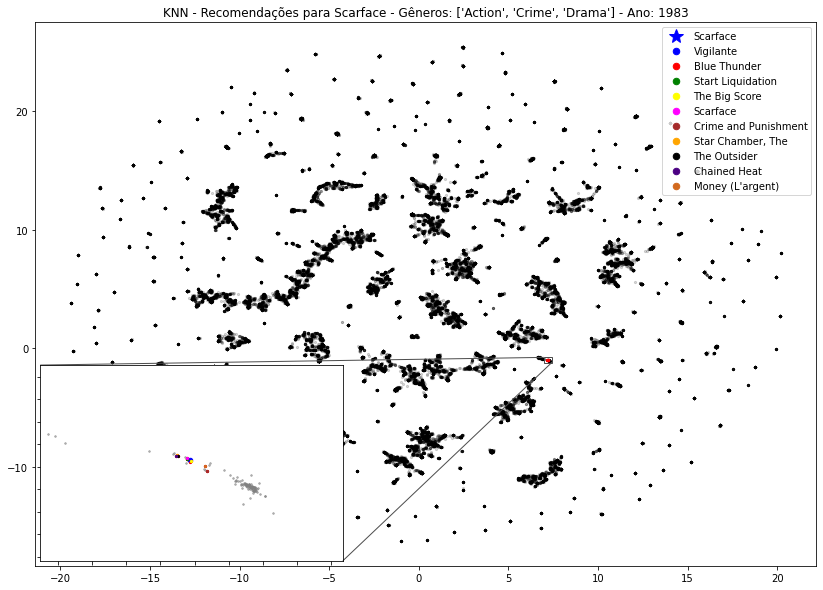

In [34]:
def callRecomendationsAndGraph(movieName, zoom):
    
    #a, b = get_recommendations_genres_cb(movieName, knn_genres_cb, movies_cb)
    a2, b2 = get_recommendations_genres_cb2(movieName, knn_cb2, movies_cb)
    
    plotKNN(movieName, movies_cb, a2, b2, zoom)

callRecomendationsAndGraph(movieName, 38)

In [35]:
genres_list.sort()
print(genres_list)
print(len(genres_list))

['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
20


In [85]:
# movies_cb.year.unique()

# year_labels = []
# for row in np.array(sparse_matrix_cb.todense().tolist()): #row[20] == year
#     year_labels.append(str(int(row[20])))
    
# year_labels = np.array(year_labels)


year_labels = np.array(sparse_matrix_cb.getcol(20).todense().tolist()).reshape(1, 62423)[0]


filtered_year_labels = [value for value in year_labels if value != 0]


1874.0


In [37]:
#umap.plot.points(trans, labels=year_labels, theme='darkblue', color_key_cmap='Paired')   

In [79]:
import matplotlib
def _to_hex(arr):
    return [matplotlib.colors.to_hex(c) for c in arr]

def _get_embedding(umap_object):
    if hasattr(umap_object, "embedding_"):
        return umap_object.embedding_
    elif hasattr(umap_object, "embedding"):
        return umap_object.embedding
    else:
        raise ValueError("Could not find embedding attribute of umap_object")

In [100]:
from bokeh.models import ColorBar
from bokeh.transform import linear_cmap

umap.plot.output_notebook()
p = umap.plot.interactive(trans, labels=year_labels, hover_data=movies_cb, point_size=2)

#LEGENDA
color_key_cmap = "Spectral"

unique_labels = np.unique(labels)
num_labels = unique_labels.shape[0]
color_key = _to_hex(
    plt.get_cmap(color_key_cmap)(np.linspace(0, 1, num_labels))
)


mapper = linear_cmap(field_name='year', palette=color_key ,low=min(filtered_year_labels) ,high=max(year_labels))
color_bar = ColorBar(color_mapper=mapper['transform'], width=10)



p.add_layout(color_bar, 'right')


# add a title to your legend
p.legend.title = "Obervations"

umap.plot.show(p)


Loading BokehJS ...